# Lectures 1

## 1. Decision Trees

![](./img/L1/3_2_41c1793bef.png)
[source](https://education.yandex.ru/handbook/ml/article/reshayushchiye-derevya)

### 1.1 Desision Trees Algorithms


```python
min_loss = inf
optimal_border = None

for j in range(D):
    for t in X[:, j]:     
        loss = calculate_loss(t, j, X, y)
        if loss < min_loss:
           min_loss, optimal_border = loss, (j, t)
```

### 1.2 Desision Trees Problems

In [75]:
%pylab inline
import numpy as np
import pandas as pd
import pylab as plt
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style='whitegrid')

from matplotlib.colors import ListedColormap
from sklearn import tree

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [8]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [27]:
colors = ['red', 'green']
cmap = ListedColormap(colors)

In [56]:
POINT_COUNT = 100

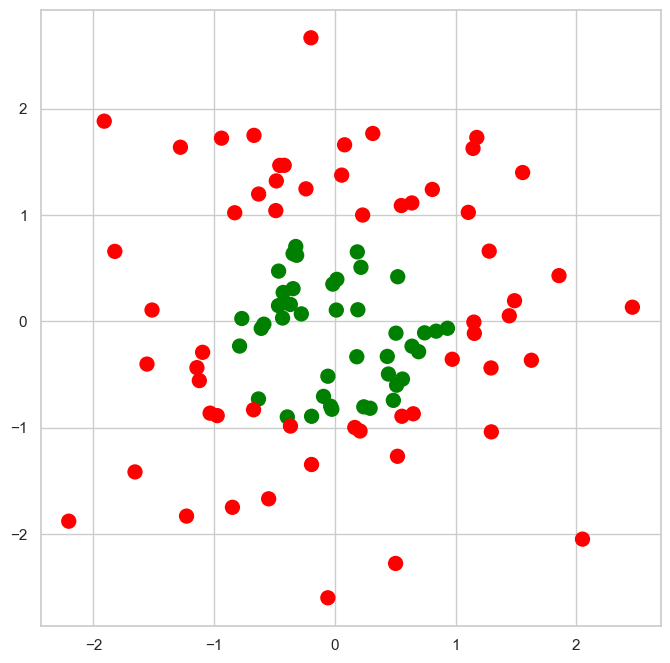

In [57]:
np.random.seed(52)
data_x = np.random.normal(size=(POINT_COUNT, 2))
data_y = np.zeros(POINT_COUNT)
data_y[((data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5 <= 1)] = 1
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap=cmap)
plt.show()

In [58]:
from sklearn.tree import DecisionTreeClassifier

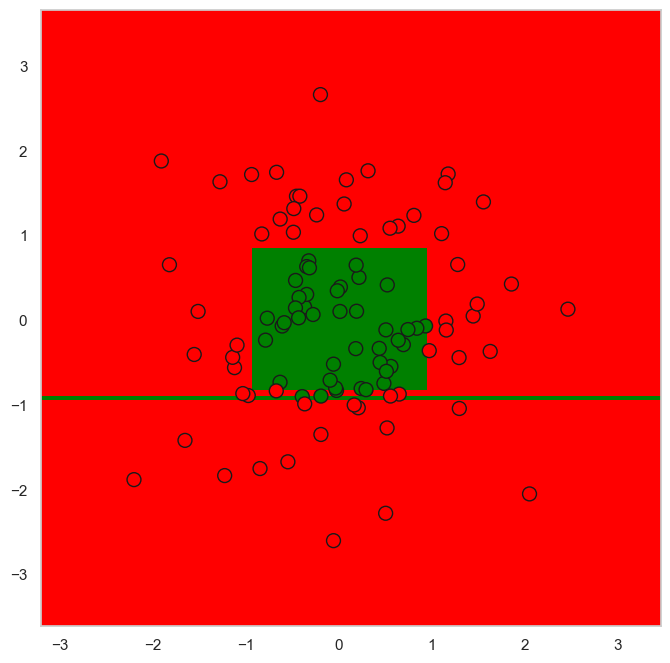

In [77]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap=cmap)
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap=cmap, edgecolor='k')

[Text(0.6, 0.9, 'x[1] <= 0.851\ngini = 0.487\nsamples = 100\nvalue = [58.0, 42.0]'),
 Text(0.5, 0.7, 'x[1] <= -0.829\ngini = 0.496\nsamples = 77\nvalue = [35, 42]'),
 Text(0.2, 0.5, 'x[1] <= -0.942\ngini = 0.172\nsamples = 21\nvalue = [19, 2]'),
 Text(0.1, 0.3, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]'),
 Text(0.3, 0.3, 'x[1] <= -0.893\ngini = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(0.2, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.4, 0.1, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.8, 0.5, 'x[0] <= 0.953\ngini = 0.408\nsamples = 56\nvalue = [16, 40]'),
 Text(0.7, 0.3, 'x[0] <= -0.941\ngini = 0.227\nsamples = 46\nvalue = [6, 40]'),
 Text(0.6, 0.1, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.8, 0.1, 'gini = 0.0\nsamples = 40\nvalue = [0, 40]'),
 Text(0.9, 0.3, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.7, 0.7, 'gini = 0.0\nsamples = 23\nvalue = [23, 0]')]

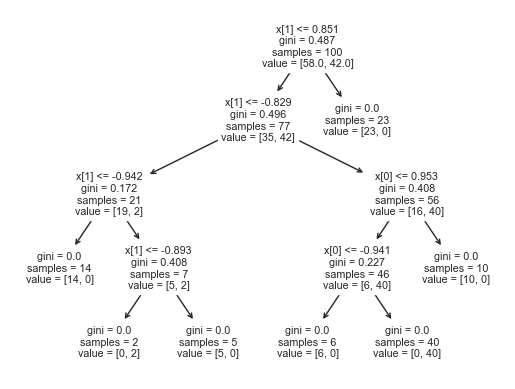

In [78]:
tree.plot_tree(clf)

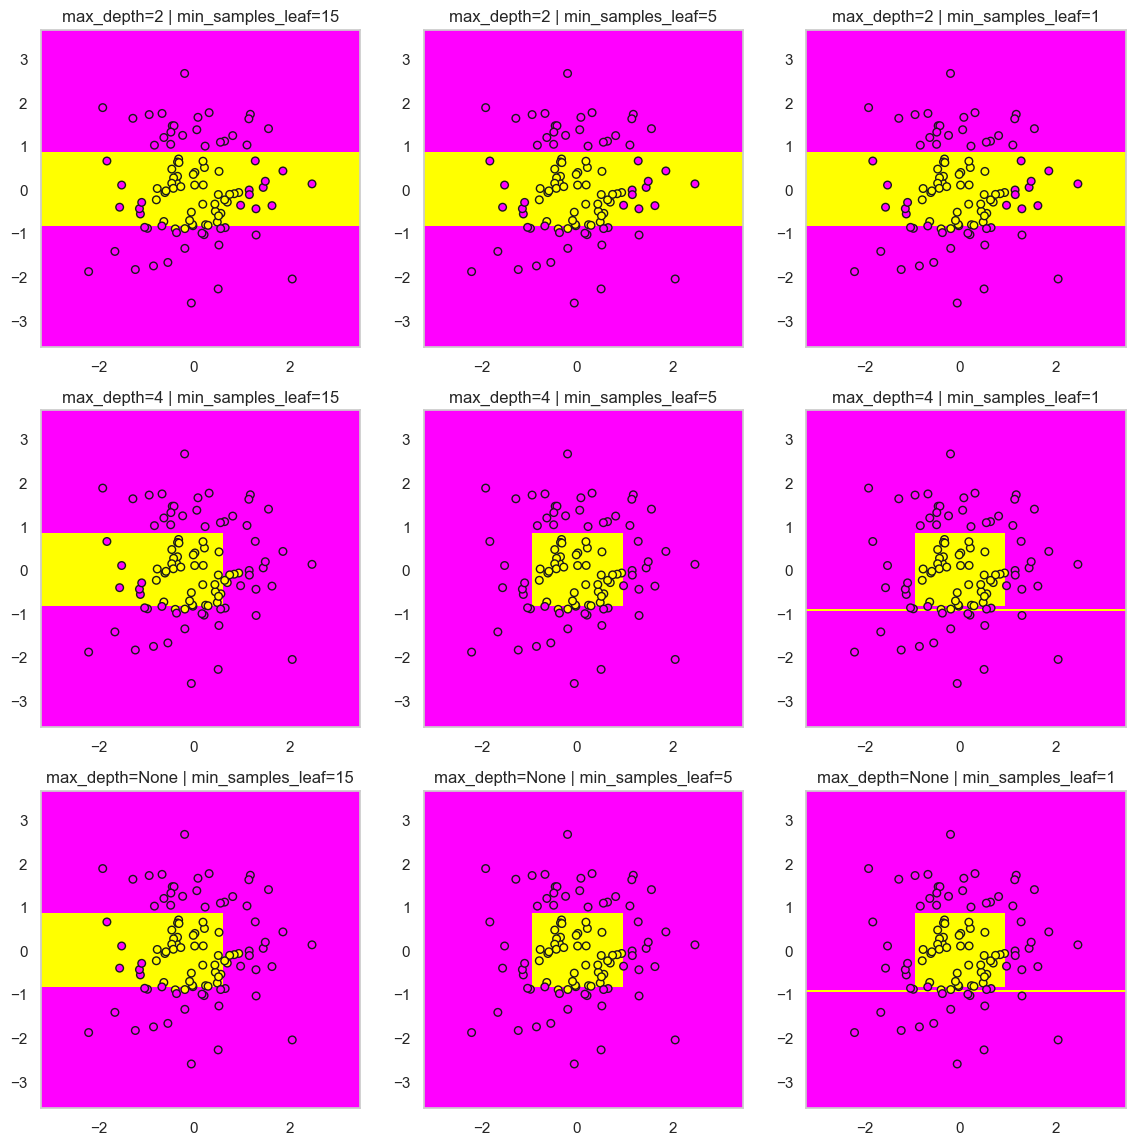

In [70]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ' | min_samples_leaf=' + str(min_samples_leaf))

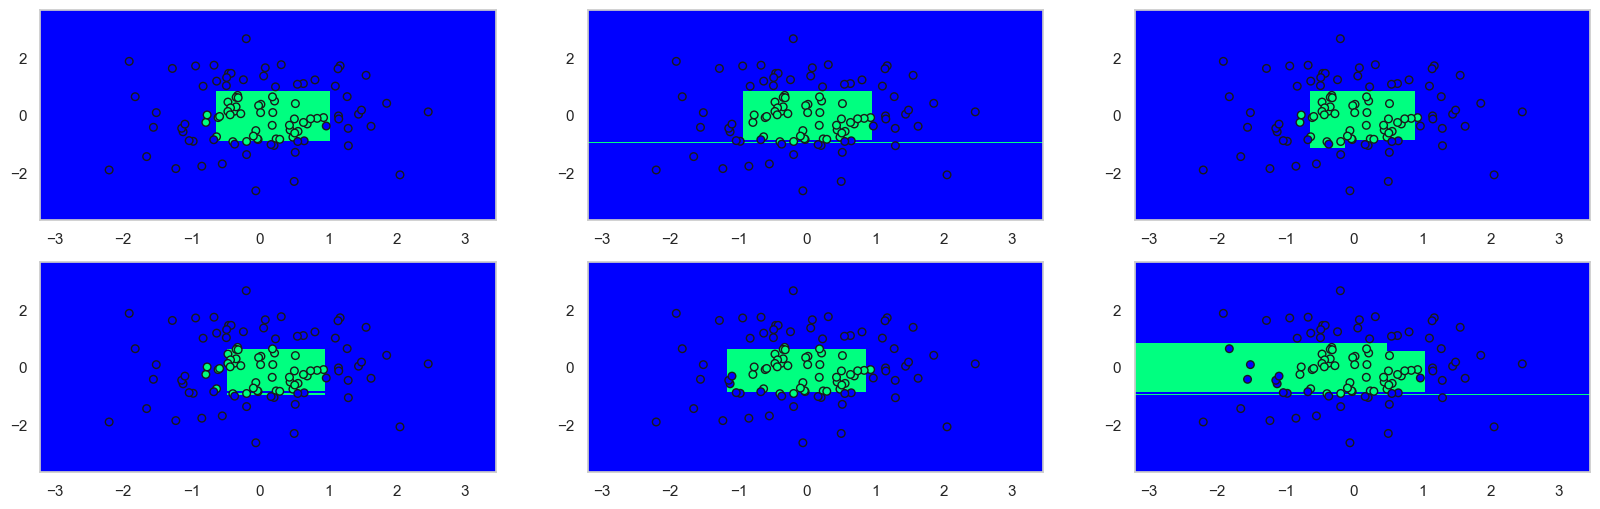

In [73]:
plt.figure(figsize=(20, 6))
for i in range(6):
    clf = DecisionTreeClassifier(random_state=52)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.75))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((2, 3), (i//3, i%3))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

# 2. Bagging